# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [4]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [5]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:43<00:00, 2005.18it/s]


In [22]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [190]:
final['Cleaned_Text']=preprocessed_reviews
print(final.shape)

(87773, 11)


In [191]:
print(final.head())

          Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
70677  76870  B00002N8SM  A19Q006CSFT011           Arlielle   
70676  76869  B00002N8SM  A1FYH4S02BW7FN           wonderer   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV      eyeofthestorm   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
70677                     0                       0      0  1288396800   
70676                     0                       0      0  1290038400   
70675                     0                       0      0  1306972800   

                                       Summary  \
22620                            made in china   
22621                        Dog Lover Delites   
70677                  onl

# [4] Featurization

## [4.1] BAG OF WORDS

In [207]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final, final['Score'], test_size=0.25, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


count_vect = CountVectorizer(min_df = 10) #in scikit-learn
final_X_train = count_vect.fit_transform(X_train['Cleaned_Text'].values)
final_X_test =  count_vect.transform(X_test['Cleaned_Text'].values)
final_X_cv = count_vect.transform(X_cv['Cleaned_Text'].values)

(49371, 11) (49371,)
(16458, 11) (16458,)
(21944, 11) (21944,)


In [209]:
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_X_train = preprocessing.normalize(final_X_train)
final_X_test = preprocessing.normalize(final_X_test)
final_X_cv = preprocessing.normalize(final_X_cv) 
print("the type of count vectorizer ",type(final_X_train))
print("the shape of out text BOW vectorizer ",final_X_train.get_shape())
print("the number of unique words ", final_X_train.get_shape()[1])

some feature names  ['aa', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49371, 8765)
the number of unique words  8765


Best Alpha value: 0.1


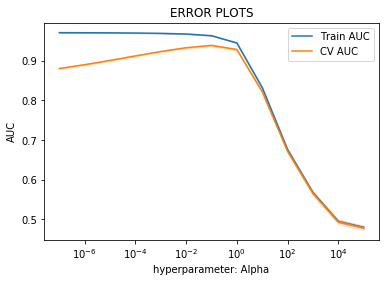

In [228]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
parameters = {'alpha' : [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]}
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc')
clf.fit(final_X_train, y_train)

optimal_alpha = alpha_range[clf.best_index_]
print("Best Alpha value:", optimal_alpha)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(alpha_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(alpha_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [229]:
# top 10  features
import operator

nb = MultinomialNB(alpha=optimal_alpha).fit(final_X_train, y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -3.722400040414687)
('great', -4.448462800724735)
('good', -4.466387728039654)
('like', -4.484125232203048)
('love', -4.778167181743118)
('one', -4.848580443542775)
('taste', -4.851615950439581)
('coffee', -4.86560567825661)
('product', -4.9142890268728125)
('flavor', -4.978936886881203)


Negative top 10 important features are:
('not', -3.1790459868506646)
('like', -4.320051914303859)
('taste', -4.553589922173062)
('product', -4.562820395015612)
('would', -4.58868729005318)
('one', -4.865839753334306)
('good', -5.002452686314389)
('coffee', -5.036229677997408)
('flavor', -5.036272942222792)
('no', -5.148154887341167)


In [28]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ", (len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in Recall matrix",A.sum(axis=1))

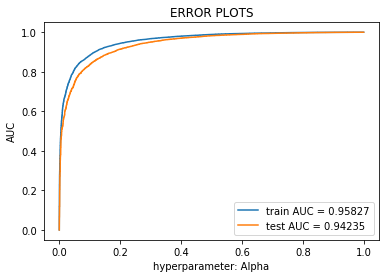

In [237]:
from sklearn.metrics import roc_curve, auc
nb = MultinomialNB(alpha=optimal_alpha)

# fitting the model
nb.fit(final_X_train, y_train)

# predict the response
pred = nb.predict(final_X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, nb.predict_proba(final_X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, nb.predict_proba(final_X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  11.88349435903668
-------------------------------------------------- Confusion matrix --------------------------------------------------


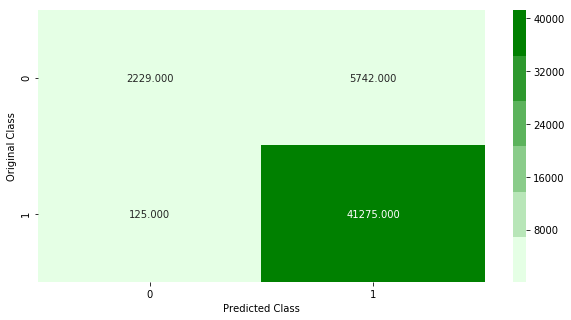

-------------------------------------------------- Precision matrix --------------------------------------------------


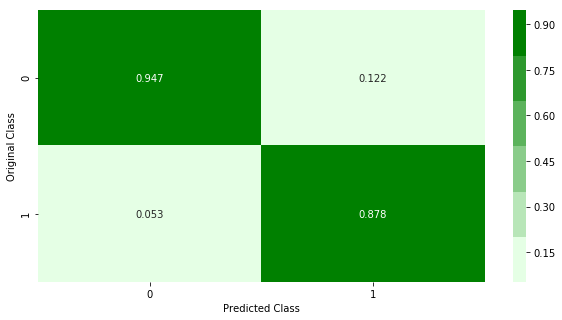

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


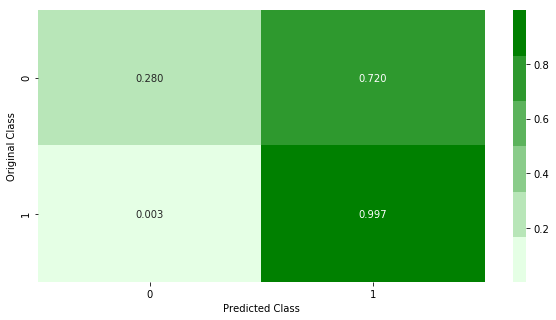

Sum of rows in Recall matrix [1. 1.]


In [235]:
plot_confusion_matrix(y_train, nb.predict(final_X_train))

Percentage of misclassified points  12.746080933284725
-------------------------------------------------- Confusion matrix --------------------------------------------------


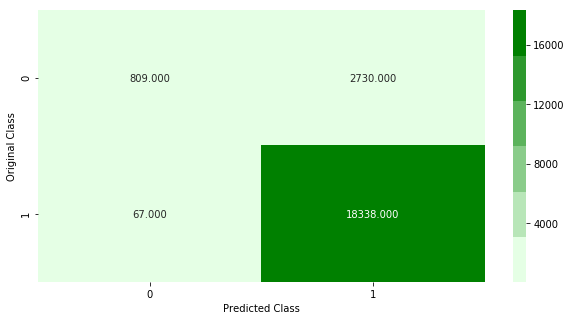

-------------------------------------------------- Precision matrix --------------------------------------------------


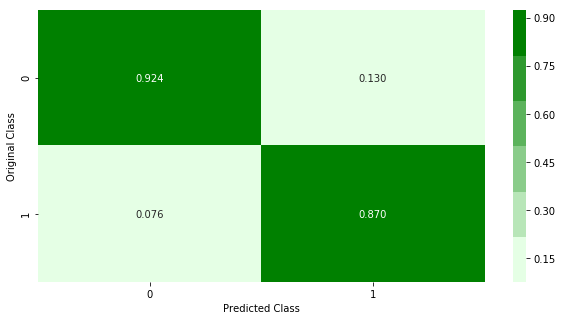

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


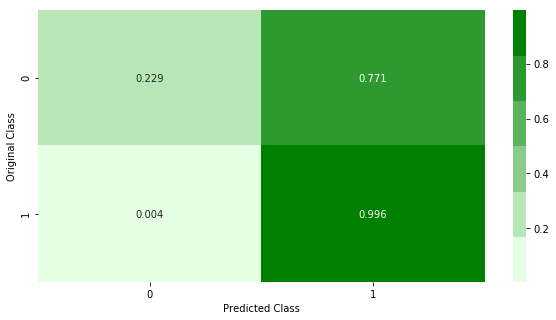

Sum of rows in Recall matrix [1. 1.]


In [236]:
plot_confusion_matrix(y_test, nb.predict(final_X_test))

### Observations:
1. Used 100k datapoints in building this model.
2. with best alpha of 0.1, the model has an roc_auc score of ~96% and ~94% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. By looking at the above observations, the model is performing good for positive data points but NOT OK on predicting the negative reviews. May be if we can change the BOW using ngrams, the model may perform better.

## [4.2] TF-IDF

In [243]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

tfidf_X_train = tf_idf_vect.fit_transform(X_train['Cleaned_Text'].values)
tfidf_X_test = tf_idf_vect.transform(X_test['Cleaned_Text'].values)
tfidf_X_cv = tf_idf_vect.transform(X_cv['Cleaned_Text'].values)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_cv = preprocessing.normalize(tfidf_X_cv)
print("the type of count vectorizer ",type(tfidf_X_train))
print("the shape of out text TFIDF vectorizer ",tfidf_X_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_X_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49371, 29361)
the number of unique words including both unigrams and bigrams  29361


Best Alpha value: 0.1


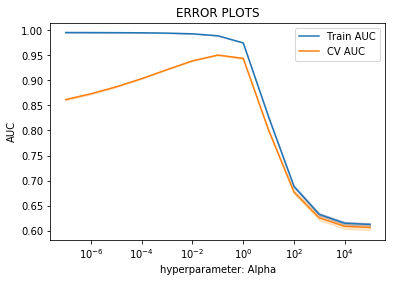

In [244]:
train_auc = []
cv_auc = []
alpha_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
parameters = {'alpha' : [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]}
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidf_X_train, y_train)

optimal_alpha = alpha_range[clf.best_index_]
print("Best Alpha value:", optimal_alpha)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(alpha_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(alpha_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [245]:
nb = MultinomialNB(alpha=optimal_alpha).fit(tfidf_X_train, y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -5.26582406094695)
('great', -5.6127169035384155)
('good', -5.668075444678985)
('like', -5.720169943968559)
('coffee', -5.75330073954542)
('love', -5.836739834736224)
('tea', -5.853022313611603)
('one', -5.9613226525682315)
('taste', -5.964013564238701)
('product', -5.982324880404968)


Negative top 10 important features are:
('not', -4.730767872201165)
('like', -5.563482263227751)
('product', -5.633958844554164)
('taste', -5.6701380788541975)
('would', -5.671928469231304)
('coffee', -5.923014562064332)
('one', -5.992006800071237)
('flavor', -6.0875461188288185)
('no', -6.131807442088112)
('good', -6.207448093636752)


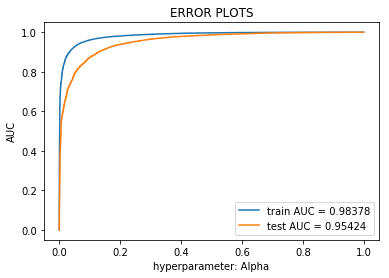

In [246]:
from sklearn.metrics import roc_curve, auc
nb = MultinomialNB(alpha=optimal_alpha)

# fitting the model
nb.fit(tfidf_X_train, y_train)

# predict the response
pred = nb.predict(tfidf_X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, nb.predict_proba(tfidf_X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, nb.predict_proba(tfidf_X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  6.240505559944097
-------------------------------------------------- Confusion matrix --------------------------------------------------


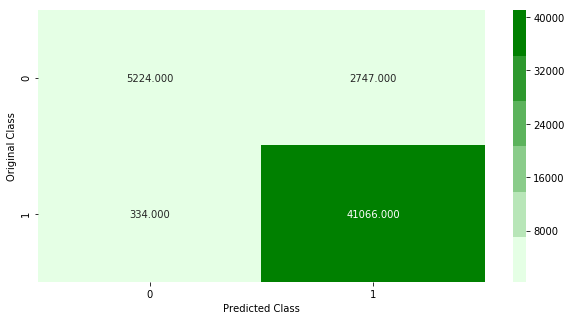

-------------------------------------------------- Precision matrix --------------------------------------------------


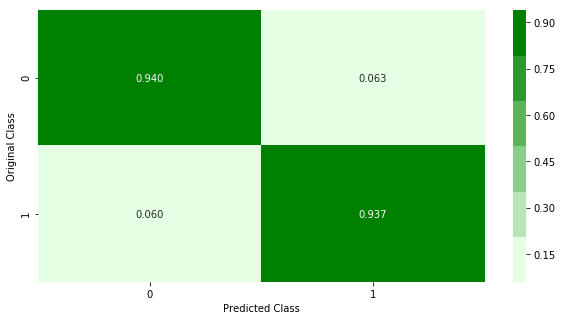

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


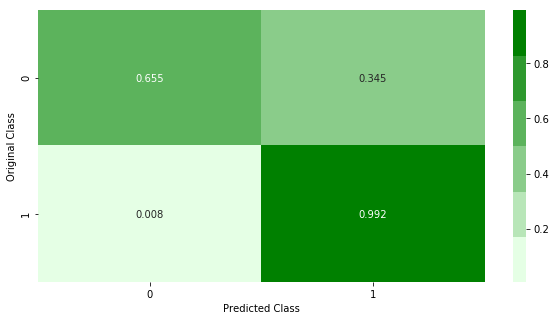

Sum of rows in Recall matrix [1. 1.]


In [247]:
plot_confusion_matrix(y_train, nb.predict(tfidf_X_train))

Percentage of misclassified points  9.401203062340503
-------------------------------------------------- Confusion matrix --------------------------------------------------


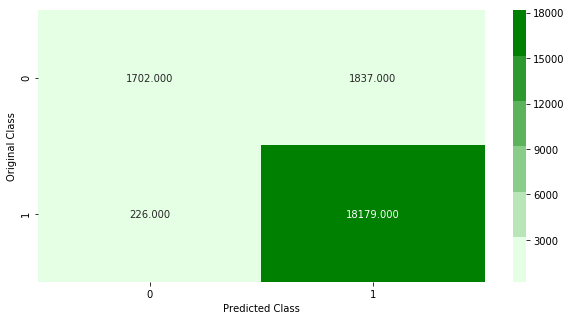

-------------------------------------------------- Precision matrix --------------------------------------------------


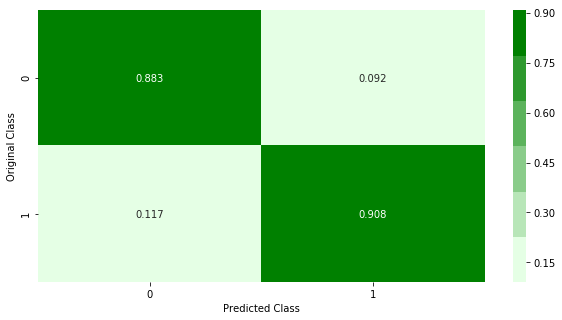

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


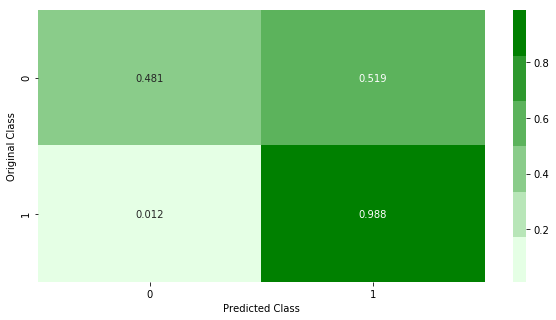

Sum of rows in Recall matrix [1. 1.]


In [248]:
plot_confusion_matrix(y_test, nb.predict(tfidf_X_test))

# Observations

1. We have used 100k datapoints only to build the model
2. with best alpha of 0.1, the model has roc_auc of ~98% and ~95% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. The AUC for the tf-idf is ~0.96 which is very good compared to BOW (unigram) with AUC of ~0.94. In this case, tf-idf performed better than BOW (unigram) but still the tf-idf also needs to perform better on negative reviews as well.
4. If we can train the model with ngrams, the model may perform better.

In [249]:
# Pretty print

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["BOW", 'MNB', 0.1 , 0.94])
x.add_row(["TF-IDF", 'MNB', 0.1 , 0.96])


print(x)

+------------+-------+-----------------+------+
| Vectorizer | Model | Hyper Parameter | AUC  |
+------------+-------+-----------------+------+
|    BOW     |  MNB  |       0.1       | 0.94 |
|   TF-IDF   |  MNB  |       0.1       | 0.96 |
+------------+-------+-----------------+------+
